### Train ETH data to CNN generative network

In [ ]:
!pip install -U "ray[data,train,tune,serve]"

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    use_gpu = True
    print('Good to go')
else:
    device = 'cpu'
    use_gpu = False
    print('Using cpu')

Using cpu


/home/qubot/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
from ReadData import ReadCurrentAndField_CNN
import glob
import os 

# TODO zhoujing edit this Data loading 
# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
train_file_num= 146
#data = ReadFolder(foldername,filepattern)
current,data = ReadCurrentAndField_CNN (foldername,filepattern,train_file_num)

fileList = glob.glob(foldername+filepattern)
position = data[:,0:3,2:18,2:18,2:18]
Bfield = data[:,3:,2:18,2:18,2:18]

# print(fileList)
print(data.shape)
print('current shape', current.shape)
print('Bfield shape', Bfield.shape)

torch.Size([146, 6, 21, 21, 21])
current shape torch.Size([146, 12])
Bfield shape torch.Size([146, 3, 16, 16, 16])


In [ ]:
from Neural_network import Generative_net,Generative_net_test ,ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
###############################################
# Config the neural network
###############################################
num_input = 8
output_shape = (3,16,16,16)
SB_args = (64,64,1,4) # (Cin, Cout, num_repeat, num_block)
BB_args = (2,3) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock
DF = False # whether using divergence free model

Generative_network = Generative_net_test(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
print(Generative_network)

from torchviz import make_dot
import torch.nn.functional as F
from Training_loop import grad_loss_Jacobain
x = torch.randn(2,8)
y = Bfield[0:2]
preds = Generative_network(x)
print(preds.shape)
loss =   F.l1_loss(preds,y)+grad_loss_Jacobain(preds,y)
        # optimizer.zero_grad() #zero out all of gradient
loss.backward()

make_dot(loss, params=dict(Generative_network.named_parameters()))


### Tune hyperparameters

In [38]:
from Neural_network import eMNS_Dataset
from Training_loop_v2 import train_GM
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
from ray.tune.tuner import Tuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray

# construct dataset
dataset = eMNS_Dataset(
    x=current,
    y=Bfield
)
# split the dataset to train, validation, test
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.85,0.1,0.05])

# normailzation
extremes = dataset.train_norm(train_indices = train_set.indices)

tune_schedule = ASHAScheduler(
        metric="rmse_val", # metric to optimize. This metric should be reported with tune.report()
        mode="min",
        max_t=350,
        grace_period=350, # minimum stop epoch
        reduction_factor=2,
    )
param_space = {
    "scaling_config": ScalingConfig(
        num_workers = 1,
        use_gpu = use_gpu,
        resources_per_worker = {"CPU":4, "GPU":0}
    ),
    # You can even grid search various datasets in Tune.
    # "datasets": {
    #     "train": tune.grid_search(
    #         [ds1, ds2]
    #     ),
    # },
    "train_loop_config": {
                'epochs': 350,
                'lr_max': tune.grid_search([1e-3,1e-4,5e-4]),
                'lr_min': tune.grid_search([1e-5,2.5e-6,2.5e-7]),
                'batch_size': 8,
                'L2_norm'   : 0,
                'verbose': False,
                'DF'     : False,
                'schedule': [],
                'grid_space': 16**3,
                'learning_rate_decay': 0.5,
                'skip_spacing': 2,
                'num_repeat'  : 1,
                'num_block'   : 3,
                'maxB'        : extremes[2],
                'minB'        : extremes[3],
                'train_set'   : train_set,
                'valid_set'   : valid_set,
                'num_input'   : 12,
            }

}

train_percents = np.arange(1.0,1.01,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
mse_history_end = np.zeros(len(train_percents))
mse_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################

train_loop_config = {
                'epochs': 10,
                'lr_max': 5e-4,
                'lr_min': 2.5e-6,
                'batch_size': 8,
                'L2_norm'   : 0,
                'verbose': False,
                'DF'     : False,
                'schedule': [],
                'grid_space': 16**3,
                'learning_rate_decay': 0.5,
                'skip_spacing': 2,
                'num_repeat'  : 1,
                'num_block'   : 3,
                'maxB'        : extremes[2],
                'minB'        : extremes[3],
                'device'      : device,
                'train_set'   : train_set,
                'valid_set'   : valid_set,
                'num_input'   : 12,
                # You can even grid search various datasets in Tune.
                # "datasets": tune.grid_search(
                #         [ds1, ds2]
                #     ),
}

scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = use_gpu,
    # resources_per_worker = {"CPU":4, "GPU":1}
)

run_config = RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=1),storage_path='~/Trained_model', 
                       name='EMS_CNN_'+'s_'+str(train_loop_config['skip_spacing'])+'r_'+str(train_loop_config['num_repeat'])+'b_'+str(train_loop_config['num_block']) )

# def train_loop_per_worker(params):
#     train_GM(train_set=train_set, valid_set=valid_set,  device=device, config=params)

trainer = TorchTrainer(
    train_loop_per_worker = train_GM,
    train_loop_config = train_loop_config,
    scaling_config = scaling_config,
    run_config = run_config,

)
# train the model
result = trainer.fit()
#----------------------------------------------
# tuner = tune.Tuner(
#     trainer,
#     param_space = param_space,
#     tune_config =tune.TuneConfig(
#         scheduler=tune_schedule,
#         num_samples=1, # number of samples of hyperparameter space
#     ),
#     # run_config = RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=2),storage_path="/home/qubot/ray_results", name="test_experiment"),
                            # checkpoint_score_attribute='rmse_val', checkpoint_score_order='min
# )
# # tune the model    
# results = tuner.fit()

(TorchTrainer pid=20581) Started distributed worker processes: 
(TorchTrainer pid=20581) - (ip=192.168.8.117, pid=20651) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=20651) Setting up process group for: env:// [rank=0, world_size=1]


(RayTrainWorker pid=20651) Epoch 0, Iteration 16, loss = 0.1583, l1 loss=0.1200, grad loss=0.0383
(RayTrainWorker pid=20651) Got rmse 9.797602653503418


(RayTrainWorker pid=20651) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/Trained_model/EMS_CNN_s_2r_1b_3/TorchTrainer_0385f_00000_0_2024-03-21_11-56-36/checkpoint_000000)


(RayTrainWorker pid=20651) Got rmse 8.676706314086914
(RayTrainWorker pid=20651) 


2024-03-21 11:56:48,192	WARNING experiment_state.py:323 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.


(RayTrainWorker pid=20651) Epoch 1, Iteration 32, loss = 0.1101, l1 loss=0.0793, grad loss=0.0308
(RayTrainWorker pid=20651) Got rmse 6.467669486999512
(RayTrainWorker pid=20651) Got rmse 5.52919864654541
(RayTrainWorker pid=20651) 
(RayTrainWorker pid=20651) Epoch 2, Iteration 48, loss = 0.0885, l1 loss=0.0615, grad loss=0.0270
(RayTrainWorker pid=20651) Got rmse 5.83610725402832
(RayTrainWorker pid=20651) Got rmse 4.7611260414123535
(RayTrainWorker pid=20651) 
(RayTrainWorker pid=20651) Epoch 3, Iteration 64, loss = 0.0745, l1 loss=0.0504, grad loss=0.0241
(RayTrainWorker pid=20651) Got rmse 4.861945152282715
(RayTrainWorker pid=20651) Got rmse 4.036675930023193
(RayTrainWorker pid=20651) 
(RayTrainWorker pid=20651) Epoch 4, Iteration 80, loss = 0.0710, l1 loss=0.0473, grad loss=0.0238
(RayTrainWorker pid=20651) Got rmse 4.330577373504639
(RayTrainWorker pid=20651) Got rmse 3.654207944869995
(RayTrainWorker pid=20651) 
(RayTrainWorker pid=20651) Epoch 5, Iteration 96, loss = 0.0633, 

(RayTrainWorker pid=20651) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/Trained_model/EMS_CNN_s_2r_1b_3/TorchTrainer_0385f_00000_0_2024-03-21_11-56-36/checkpoint_000001)


(RayTrainWorker pid=20651) Got rmse 2.3743371963500977
(RayTrainWorker pid=20651) 


2024-03-21 11:57:19,905	WARNING experiment_state.py:323 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2024-03-21 11:57:19,911	INFO tune.py:1042 -- Total run time: 43.58 seconds (42.73 seconds for the tuning loop).


Result(
  metrics={'rmse_val': 3.169771194458008, 'rmse_train': 2.3743371963500977, 'loss': 0.045644618570804596},
  path='/home/qubot/Trained_model/EMS_CNN_s_2r_1b_3/TorchTrainer_0385f_00000_0_2024-03-21_11-56-36',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/qubot/Trained_model/EMS_CNN_s_2r_1b_3/TorchTrainer_0385f_00000_0_2024-03-21_11-56-36/checkpoint_000001)
)


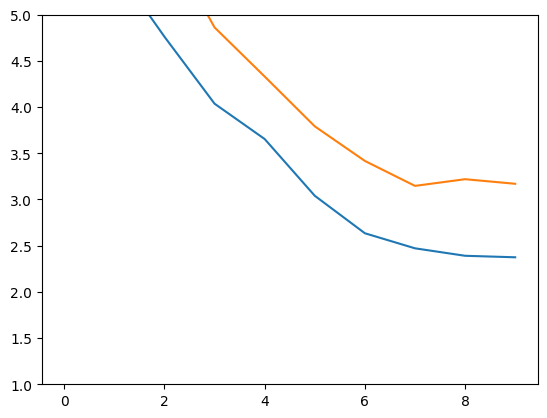

In [44]:
from utils import plot_ray_results
print(result)
plot_ray_results(result, metrics_names=['rmse_train','rmse_val'],ylim=[1,5])

In [7]:
best_result = results.get_best_result(metric='rmse_val',mode='min')
print(best_result)

AttributeError: 'Result' object has no attribute 'get_best_result'

In [ ]:
from utils import plot_ray_results
plot_ray_results(best_result, metrics_names=['rmse_train','rmse_val'])

In [ ]:
!tensorboard --logdir=~/ray_results

Got rmse 2.705864906311035
rmse for test set: 2.7059mT
 mse for test set: 7.3217mT
  R2 for test set: 0.9840
plot sample rmse: 2.2255mT


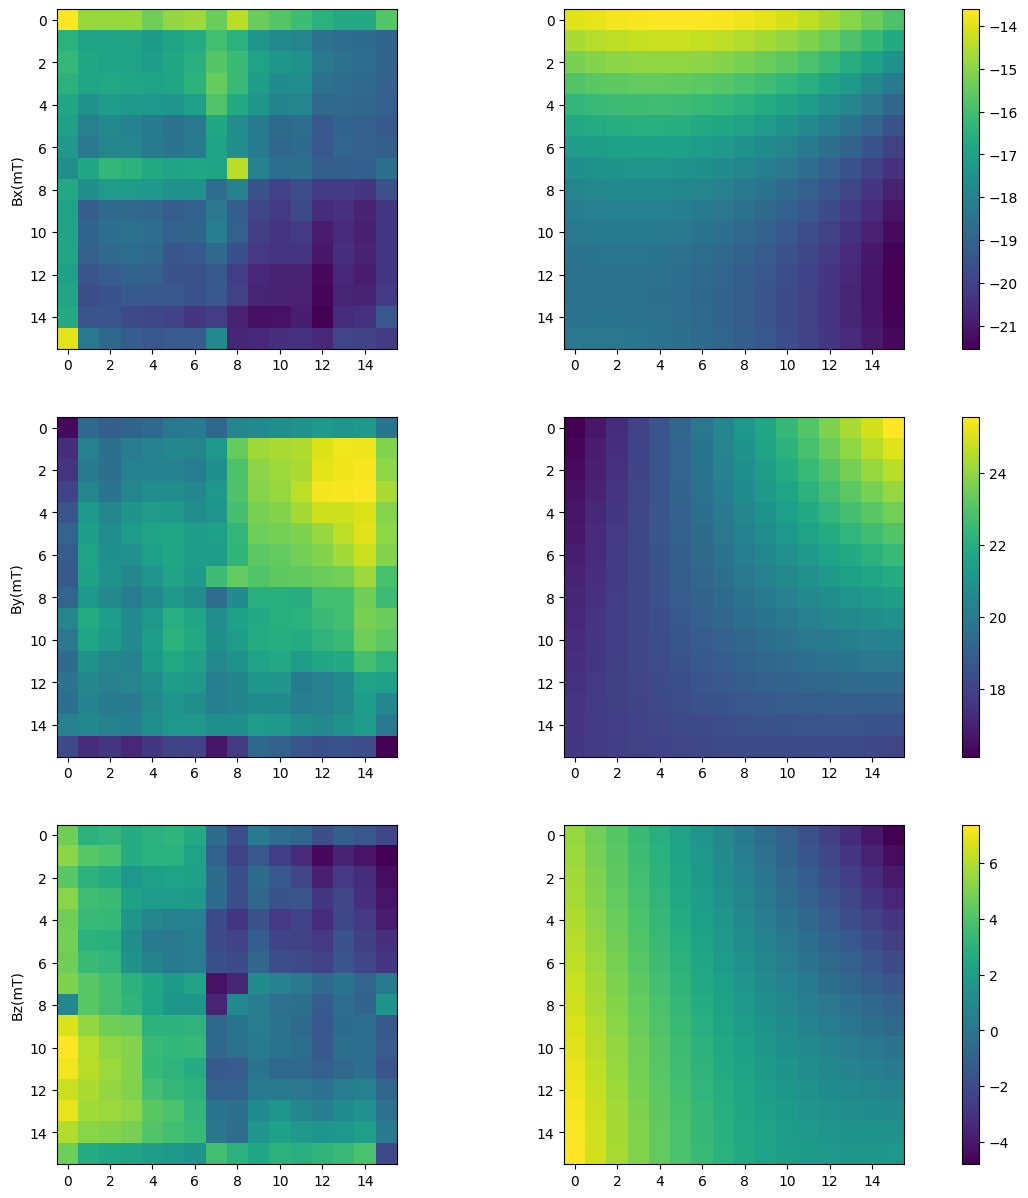

In [92]:

from utils import estimate_test_set 
test_estimator = estimate_test_set(result.checkpoint, test_set, train_loop_config)
test_estimator.fit()
test_estimator.peek_z(2)

torch.Size([16])
torch.Size([3, 16, 16, 16])
torch.Size([3, 16, 16, 16])


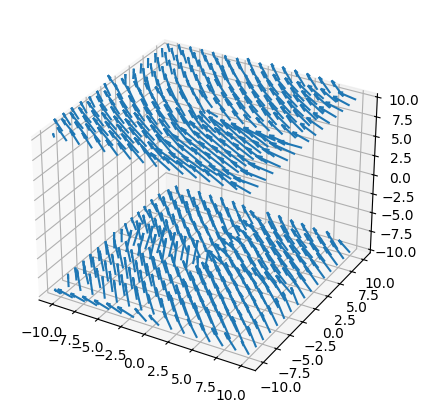

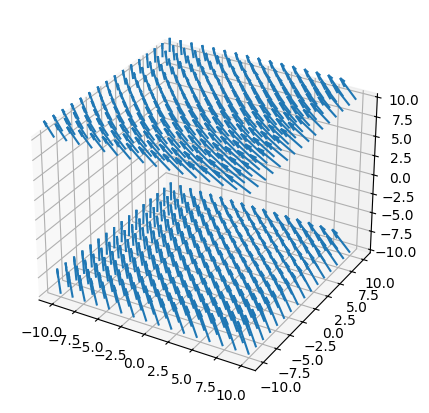

In [114]:
test_estimator.peek_3D(length=0.15)

## Old version of training loop

In [ ]:
from Neural_network import Generative_net, Generative_net_test, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
from Training_loop_v2 import train_GM
from tqdm import tqdm

# construct dataset
dataset = eMNS_Dataset(
    train_x=current,
    train_y=Bfield
)

config = {
    'epochs': 350,
    'lr_max': 1e-4,
    'lr_min': 2.5e-6,
    'batch_size': 8,
    'L2_norm'   : 0,
    'verbose': False,
    'DF'     : False,
    'schedule': [],
    'grid_space': 16**3,
    'learning_rate_decay': 0.5,
    'skip_spacing': 2,
    'num_repeat'  : 2,
    'num_block'   : 3,
    'device'      : device,
    'num_input'   : 12,
}
train_percents = np.arange(1.0,1.01,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
mse_history_end = np.zeros(len(train_percents))
mse_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)

    # split the dataset to train, validation, test
    train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

    # normailzation
    extremes = dataset.train_norm(train_indices = train_set.indices)

    config['maxB'] = extremes[2]
    config['minB'] = extremes[3]
    config['train_set'] = train_set 
    config['valid_set'] = valid_set



    print("----------------------------")
    
    print("----------------------------")
    # test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)


    
    RMSE_history, RMSE_val_history, loss_history, iter_history, mse_history, mse_val_history,epoch_stop,Rsquare = train_GM(
        config=config)
        
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    mse_history_end[index] = mse_history[epoch_stop]
    mse_val_history_end[index] = mse_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)
    print('training stop at epoch:',Rsquare)


In [ ]:
torch.save(Generative_network, 'EMS_CNN_ETH.pt')	# 这里会存储迄今最优模型的参数

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')


plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim([0,10])
plt.show()

plt.title('Train and Val RMSE(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop],'-*')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_history[0:epoch_stop]*1000,'-o')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_val_history[0:epoch_stop]*1000,'-*')
# plt.ylim([15,20])
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('RMSE(mT)')
plt.ylim([0,100])
plt.grid()
plt.show()

plt.title('Train and Val loss(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],mse_history[0:epoch_stop]*1e6,'-o')
plt.plot(iter_history[0:epoch_stop],mse_val_history[0:epoch_stop]*1e6,'-*')
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('mse(mT^2)')
plt.grid()
plt.show()
print(epoch_stop)

